In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime
import time

In [2]:
from plot_functions import plot_results_by_month
from plot_functions import plot_results_with_uncertainty_by_month
from plot_functions import plot_residuals
from plot_functions import plot_train_vs_validation_loss
from plot_functions import plot_results_with_uncertainty_by_week
from helpers import day_ahead_forecast
from helpers import extract_residuals
from helpers import extract_all_residuals
from helpers import picp
from helpers import pinaw

In [3]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

## Model Training

In [ ]:
file_path = os.path.join(current_directory, 'data_augmented/X_train.npy')
X_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/y_train.npy')
y_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_train.csv')
timestamps_train = pd.read_csv(file_path, parse_dates=True)
timestamps_train = timestamps_train.index

file_path = os.path.join(current_directory, 'data_augmented/X_test.npy')
X_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/y_test.npy')
y_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_test.csv')
timestamps_test = pd.read_csv(file_path, index_col=0, parse_dates=True)
timestamps_test = timestamps_test.index

In [ ]:
forecast_horizon = 24

In [12]:
print('Train set dimensions:')
print(X_train.shape)
print(y_test.shape)
print('Test set dimensions:')
print(X_test.shape)
print(y_test.shape)

Train set dimensions:
(17954, 168, 32)
(745, 24)
Test set dimensions:
(745, 168, 32)
(745, 24)


In [14]:
# Define NN
import torch
import torch.nn as nn

class TemporalConvNet(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        """
        Temporal Convolutional Network for Power Consumption Forecasting.

        Parameters:
            input_size (int): Number of input features.
            output_size (int): Number of output features (forecast horizon).
            num_channels (list): Number of channels in each TCN layer.
            kernel_size (int): Size of the convolution kernel.
            dropout (float): Dropout rate.
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=(kernel_size - 1)),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        """
        Forward pass of the TCN.

        Input:
            x: Shape (batch_size, seq_length, input_size).
        Output:
            y: Shape (batch_size, output_size).
        """
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_size, seq_length)
        x = self.network(x)
        x = x[:, :, -1]  # Take the last time step
        x = self.linear(x)
        return x
    
    def enable_mc_dropout(self):
        """Enable MC Dropout by setting all dropout layers to train mode."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

In [15]:
# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use the MPS device for Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Default to CPU if no GPU backend is available

print(f"Using device: {device}")

Using device: cpu


**Dropout**
Dropout randomly disables a fraction of neurons during training to reduce reliance on specific neurons, promoting generalization.
Increase the dropout rate (e.g., 0.3 or 0.5) to enforce stronger regularization.
**Stride**
Stride controls how much the convolution kernel moves along the sequence. A larger stride reduces the number of computations and introduces a form of downsampling.
Increasing the stride (e.g., stride = 2) reduces the model's capacity by aggregating features more aggressively. This may help with overfitting but can also lose fine-grained temporal information.
**Number of hidden channels**
Determines the number of filters in each TCN layer, controlling model capacity.
Reduce the number of channels (e.g., $[32, 64, 32]$) to decrease the model's capacity and reduce the risk of overfitting.
**Kernel**
Determines the size of the convolutional filter. Larger kernels allow the model to capture broader temporal patterns but increase complexity.
Keep it small (3 or 5) to limit capacity and focus on short-term temporal dependencies.
**Weight regularization** 
Add L1 or L2 regularization to the optimizer to penalize large weights.
**Batch size**
Use larger batch sizes to improve the robustness of gradient updates.
**Early Stopping**
Monitor validation loss and stop training when it stops improving to prevent overfitting to the training set.
**Learning rate**
Use a smaller learning rate to make more refined updates to the weights.

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# Initialize the TCN model
input_size = X_train.shape[2]  # Number of features per time step
output_size = y_train.shape[1]  # Forecast horizon (24 hours)
hidden_channels = [32, 64, 32] # [64, 128, 64]  # Number of channels in hidden layers
dropout_rate = 0.3
kernel_size = 3

model = TemporalConvNet(input_size, output_size, hidden_channels, kernel_size=kernel_size, dropout=dropout_rate).to(device)

# Training setup
learning_rate = 1e-3
weight_decay = 1e-4  # L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

# Early stopping parameters
patience_limit = 5
best_val_loss = float("inf")
patience_counter = 0

# Training loop with early stopping
num_epochs = 50  # Increased epochs to allow for early stopping
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print training metrics
    epoch_loss /= len(train_loader)
    end_time = time.time()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f} seconds")

    # Early stopping logic
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor.to(device))
        val_loss = criterion(val_predictions, y_test_tensor.to(device)).item()

    print(f"Validation Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model 
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'output_size': output_size,
            'hidden_channels': hidden_channels,
            'kernel_size': kernel_size,
            'dropout': dropout_rate,
            'X_train_tensor': X_train_tensor.cpu(),
            'X_test_tensor': X_test_tensor.cpu(),
            'y_train_tensor': y_train_tensor.cpu(),
            'y_test_tensor': y_test_tensor.cpu(),
            'batch_size': batch_size 
        }, "best_tcn_model_and_data.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break

Epoch 1, Loss: 0.8317, Time: 19.91 seconds
Validation Loss: 0.4887
Epoch 2, Loss: 0.5584, Time: 20.21 seconds
Validation Loss: 0.4693
Epoch 3, Loss: 0.5311, Time: 20.95 seconds
Validation Loss: 0.4583
Epoch 4, Loss: 0.5127, Time: 20.16 seconds
Validation Loss: 0.4470
Epoch 5, Loss: 0.4967, Time: 20.19 seconds
Validation Loss: 0.4253
Epoch 6, Loss: 0.4726, Time: 20.13 seconds
Validation Loss: 0.4060
Epoch 7, Loss: 0.4633, Time: 20.08 seconds
Validation Loss: 0.3964
Epoch 8, Loss: 0.4595, Time: 20.31 seconds
Validation Loss: 0.3925
Epoch 9, Loss: 0.4515, Time: 20.28 seconds
Validation Loss: 0.3868
Epoch 10, Loss: 0.4490, Time: 20.14 seconds
Validation Loss: 0.3878
Epoch 11, Loss: 0.4443, Time: 20.21 seconds
Validation Loss: 0.3821
Epoch 12, Loss: 0.4386, Time: 20.45 seconds
Validation Loss: 0.3791
Epoch 13, Loss: 0.4370, Time: 20.15 seconds
Validation Loss: 0.3771
Epoch 14, Loss: 0.4346, Time: 20.04 seconds
Validation Loss: 0.3760
Epoch 15, Loss: 0.4339, Time: 20.25 seconds
Validation Lo

In [ ]:
# Plot train and validation losses over epochs
file_path = os.path.join(current_directory, 'results/train_vs_validation_loss_LSTM.png')
plot_train_vs_validation_loss(range(1, len(train_losses) + 1),train_losses, val_losses, file_path)

In [ ]:
y_pred = test_predictions.cpu().detach().numpy()  # Predictions, size: (num_test_samples, forecast_horizon)
y_true = y_test_tensor.cpu().numpy()  # Ground truth, size: (num_test_samples, forecast_horizon)

In [ ]:
# Test the model
checkpoint = torch.load("best_tcn_model_and_data.pth")
model.load_state_dict(checkpoint['model_state_dict']) # Load the best model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device))
    test_loss = criterion(test_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss: {test_loss:.4f}")

In [19]:
y_pred = test_predictions.cpu().detach().numpy()  # Predictions, size: (num_test_samples, forecast_horizon)
y_true = y_test_tensor.cpu().numpy()  # Ground truth, size: (num_test_samples, forecast_horizon)

In [20]:
num_samples, forecast_horizon = y_pred.shape  
prediction_timestamps = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(0, num_samples+forecast_horizon-1)]

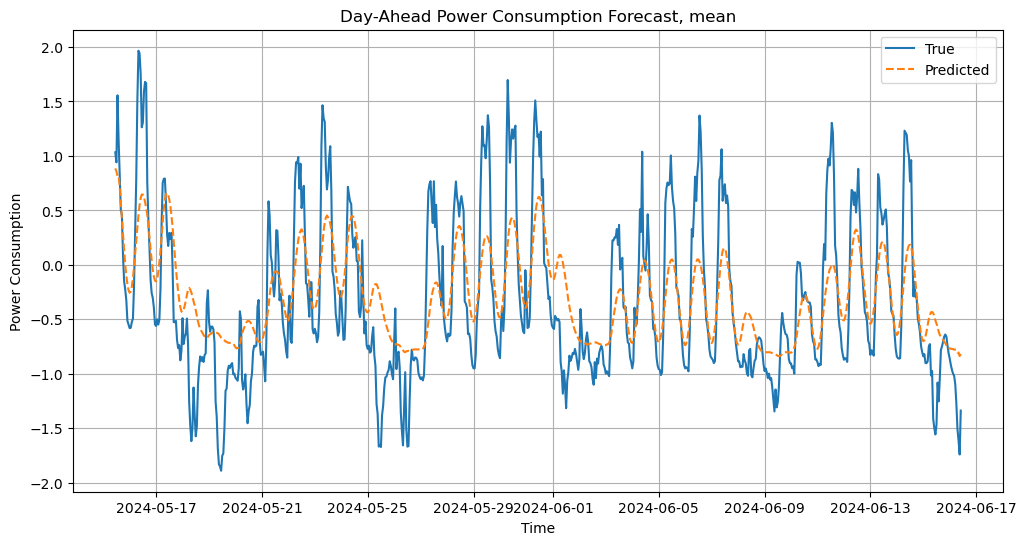

In [21]:
predictions = day_ahead_forecast(y_pred, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

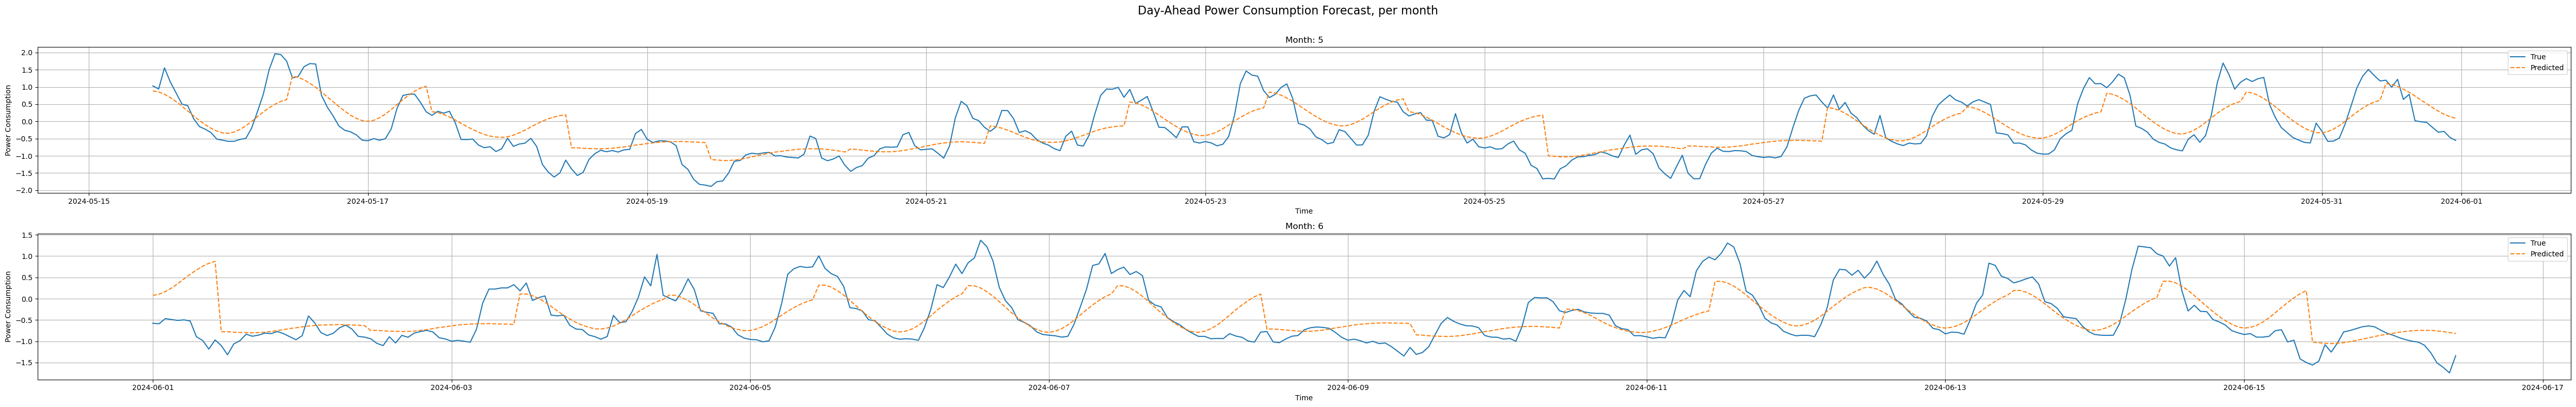

In [24]:
file_path = os.path.join(current_directory, 'results/TCN.png')
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month", file_path)

#### Prediction accuracy

In [26]:
# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [83]:
file_path = os.path.join(current_directory, 'results/errors.csv')
errors = pd.read_csv(file_path, index_col=0)

In [85]:
new_row = {'RMSE': root_mean_squared_error(actuals, predictions), 
                        'MAE': mean_absolute_error(actuals, predictions), 
                        'ME': max_error(actuals, predictions), 
                        'MAPE': mean_absolute_percentage_error(actuals, predictions)}

errors.loc['TCN'] = new_row

In [87]:
errors

,RMSE,MAE,ME,MAPE
SARIMA,23.07064,20.11793,39.16349,95.85843
Persistence forecast,0.91496,0.59467,3.52636,4.34736
LSTM,0.30826,0.22351,1.18060,0.65097
TCN,0.50746,0.37287,2.01247,1.07219


In [ ]:
file_path = os.path.join(current_directory, 'results/errors.csv')
errors.to_csv(file_path)

In [ ]:
hours = [0, 7, 12]
y_true_filtered, y_pred_filtered, residuals_filtered = extract_residuals(actuals, predictions, prediction_timestamps, hours)

In [ ]:
for i, hour in enumerate(hours):
    hour_str = str(hour)
    file_path = os.path.join(current_directory, f'results/residuals_plot_TCN_{hour_str}_am.png')
    title = f'Hour: {hour_str} am'
    plot_residuals(residuals_filtered.iloc[i].values, y_pred_filtered.iloc[i].values, title, file_path)

In [ ]:
residuals_all = y_true - y_pred
file_path = os.path.join(current_directory, f'results/residuals_plot_TCN.png')
title = 'All residuals'
plot_residuals(residuals_all, y_pred, title, file_path)

## Monte Carlo Drop Out 

In [ ]:
def monte_carlo_predictions(model, X, num_samples=100):
    """
    Perform Monte Carlo Dropout predictions.

    Parameters:
        model (nn.Module): TCN model with MC Dropout enabled.
        X (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_features).
        num_samples (int): Number of MC samples.

    Returns:
        torch.Tensor: Mean predictions.
        torch.Tensor: Prediction standard deviations (uncertainty).
    """
    model.enable_mc_dropout()  # Enable dropout during testing
    predictions = []

    for _ in range(num_samples):
        with torch.no_grad():
            predictions.append(model(X))  # Append prediction for each MC sample

    predictions = torch.stack(predictions)  # Shape: (num_samples, batch_size, output_size)
    mean_prediction = predictions.mean(dim=0)  # Mean over MC samples
    uncertainty = predictions.std(dim=0)  # Std dev over MC samples

    return mean_prediction, uncertainty

In [33]:
# Load the saved model and data
checkpoint = torch.load("best_tcn_model_and_data.pth")

# Recreate the model
model = TemporalConvNet(
    checkpoint['input_size'],
    checkpoint['output_size'],
    checkpoint['hidden_channels'],
    checkpoint['kernel_size'],
    checkpoint['dropout']
).to(device)

X_test_tensor = checkpoint['X_test_tensor'].to(device)
y_test_tensor = checkpoint['y_test_tensor'].to(device)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# === Evaluation with MC Dropout ===
model.eval()  # Enable evaluation mode

# Use MC Dropout for predictions
num_samples = 100  # Number of Monte Carlo samples
mean_predictions, uncertainties = monte_carlo_predictions(model, X_test_tensor.to(device), num_samples)

# Compute test loss using the mean prediction
learning_rate = 1e-3
weight_decay = 1e-4  # L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()
test_loss = criterion(mean_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss (MC Dropout): {test_loss:.4f}")

# Convert results to numpy arrays for further analysis
mean_predictions_np = mean_predictions.cpu().numpy()  # Mean predictions
uncertainties_np = uncertainties.cpu().numpy()  # Prediction uncertainties
y_true = y_test_tensor.cpu().numpy()  # Ground truth

Test Loss (MC Dropout): 0.3057


In [34]:
mean_predictions = day_ahead_forecast(mean_predictions_np, prediction_timestamps)
uncertainties = day_ahead_forecast(uncertainties_np, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

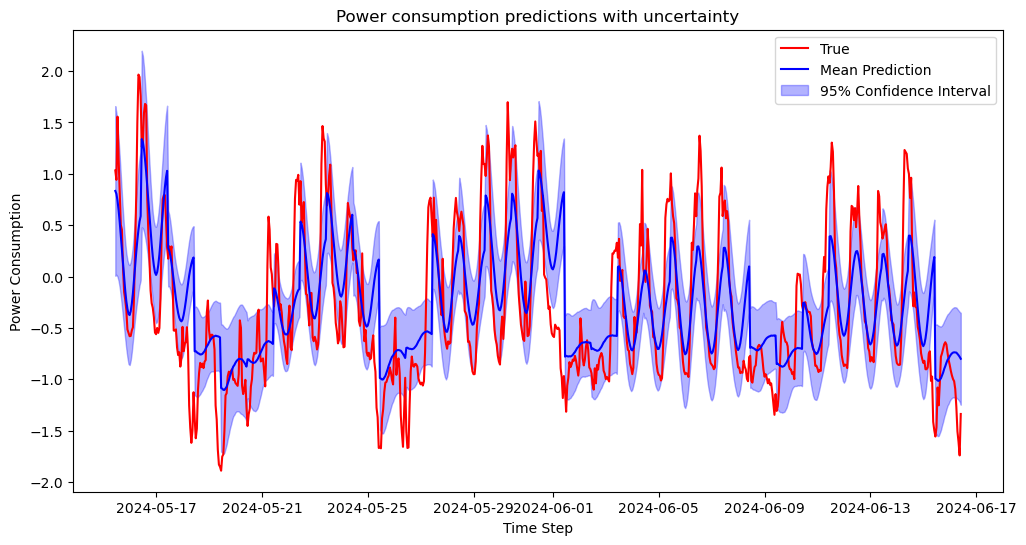

In [35]:
confidence_level = 1.96
plot_results_with_uncertainty(mean_predictions, uncertainties, confidence_level, actuals, 'Power consumption predictions with uncertainty')

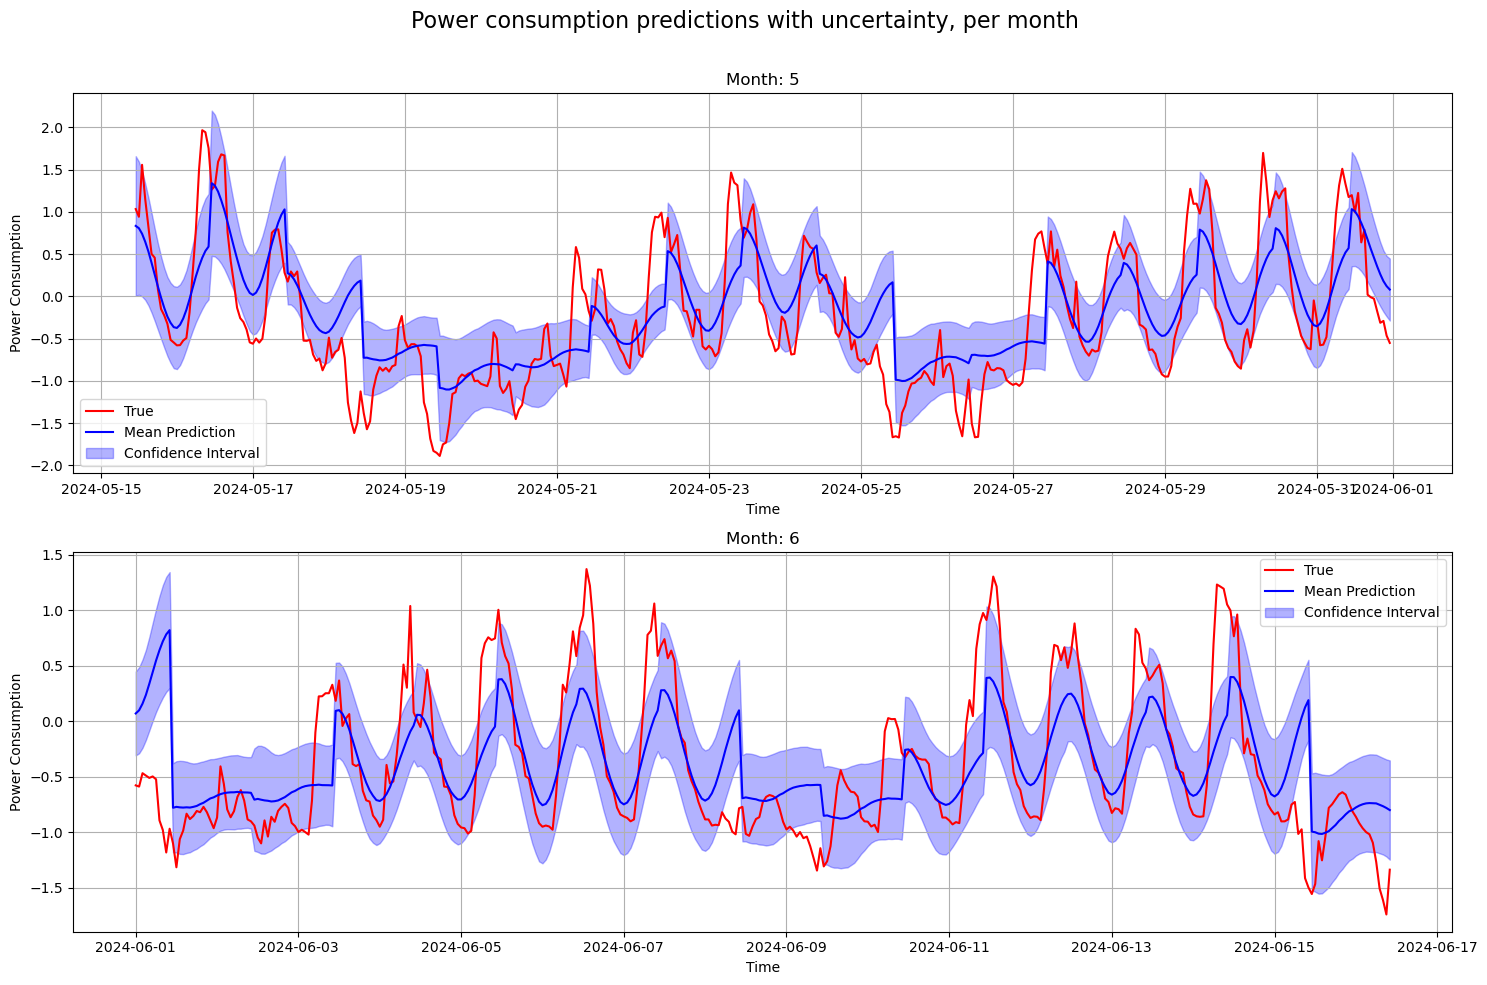

In [36]:
file_path = os.path.join(current_directory, 'results/TCN_MCDropOut.png')
plot_results_with_uncertainty_by_month(mean_predictions, uncertainties, confidence_level, actuals, 'Power consumption predictions with uncertainty, per month', file_path)

#### Uncertainty evaluation

In [ ]:
file_path = os.path.join(current_directory, 'results/uncertainty_evaluation.csv')
uncertainty_evaluation = pd.read_csv(file_path, index_col=0)

In [95]:
new_row = {'PICP': picp(actuals, mean_predictions - confidence_level * uncertainties, mean_predictions + confidence_level * uncertainties), 
                        'PINAW': pinaw(actuals, mean_predictions - confidence_level * uncertainties, mean_predictions + confidence_level * uncertainties)}

uncertainty_evaluation.loc['TCN'] = new_row

In [ ]:
file_path = os.path.join(current_directory, 'results/uncertainty_evaluation.csv')
uncertainty_evaluation.to_csv(file_path) 